# Post-processing simulation using Kuibit 

**General structure**:

- Import libraries
- Load simulation directory
    - Print all files
    - Extract available iterations: `sim.gf.xyz['kxx'].available_iterations`
    - Define `avail_iter_max = avail_iter[-1]`
    - Define `diter = avail_iter[1]-avail_iter[0]`
- Define Hamiltonian and Momentum average timeseries 

- Define GridFunctions for all available variables: 
    - Matter density `rho`
    - Extrinsic curvature `kxx` 
    - Trace of K `trK`
    - Spatial metric `gxx`
    - Determinant of g `detg`
    - Ricci tensor `Ricci11`
    - Ricci scalar `Ricci`

- Plot Hamiltonian and Momentum timeseries
    - Maybe discard some of the final iterations 

- Define corresponding background quantities (FLRW flat dust model or EdS)
    - Definitions from **ICCalc.F90**: $s=aa/a0$, $H$, $\Omega_m$
        - $\bar{K}=-3K$
        - $\bar{\gamma}=a^6$
        - $\bar{\rho}=3H^2 \Omega_m/\kappa$

    - Definitions from Robyn for $\Lambda=0$ (Validate!)
        - I think the formulas for FLRW are still valid here, and we just need to change: 
            - $s=\left(\frac{\tau}{\tau_0}\right)^{2/3}$
            - $H=\frac{2}{3\tau}$
            - $\Omega_m=1.0$    

- Define a coarse scale factor `aa_co` from timeseries, avail_iter_max and diter.
 
- Calculate redshift $z$ from coarse scale factor $a(\tau)$  

- Calculate density contrast, extrinsic curvature contrast, metric contrast     
    - Plot curves at the underdensity, underdensity and center of the box 
    - Plot outer and inner surfaces for the density contrast 
    - Try and do a 3D animation with isosurfaces of the density contrast at $z_{IN}$ to show:
        1. Spherical symmetry near to OD
        2. Filamentary-like structures
        3. Periodic Boundary conditions
        4. compensated inhomogeneity (just one lambda, linear average vanishes)

In [3]:
# Use et2 for compatibility
from kuibit.simdir import SimDir
import kuibit.visualize_matplotlib as viz
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

# set plot theme 
sns.set_theme(context='notebook', style='darkgrid', palette='colorblind')

Move functions to a `.py` once validated

In [9]:
sim = SimDir('/home/jorge/Downloads/output-0000/testPert32_F')

In [14]:
rho = sim.gf.xyz['rho']

In [19]:
rho[0][0][0].shape       # can I access cctk time from grid functions?? I think not

array([32, 32, 32])

In [10]:
M1 = sim.timeseries.average['M1']

In [ ]:
M1.x.shape      # cctk time ; notice that this stores later iterations that gridfunction don't

(39926,)

In [ ]:
cctk_time_co = M1.x[0, ]

In [12]:
M1.y

array([-1.46668275e-20,  7.12401629e-22,  1.31372881e-22, ...,
        1.50012339e-19,  1.49550900e-19,  1.49144545e-19])

In [7]:
print(sim)

Indexed 25 files and 1 subdirectories
Folder /home/jorge/Downloads/output-0000/testPert32_F
/home/jorge/Downloads/output-0000/testPert32_F
Available scalar timeseries:
[]

Available minimum timeseries:
[]

Available maximum timeseries:
[]

Available norm1 timeseries:
[]

Available norm2 timeseries:
[]

Available average timeseries:
['kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'alp', 'H', 'rho', 'betax', 'betay', 'betaz', 'M1', 'M2', 'M3']
Variables available: dict_keys([])

Available grid data of dimension 1D (x): 
[]


Available grid data of dimension 1D (y): 
[]


Available grid data of dimension 1D (z): 
[]


Available grid data of dimension 2D (xy): 
[]


Available grid data of dimension 2D (xz): 
[]


Available grid data of dimension 2D (yz): 
[]


Available grid data of dimension 3D (xyz): 
['kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'Ricci11', 'Ricci12', 'Ricci13', 'Ricci22', 'Ricci23', 'Ricci33', 'Ricci', 'rho', 'gxx', 'gxy', 'gxz', 'gyy',

In [20]:
# Available iterations

avail_iter = sim.gf.xyz['kxx'].available_iterations 
print(f'{sim.gf.xyz['kxx'].available_iterations[:3]} ... {sim.gf.xyz['kxx'].available_iterations[-3:]}')

[0, 80, 160] ... [39760, 39840, 39920]


In [85]:
avail_iter_max = avail_iter[-1]
diter = avail_iter[1]-avail_iter[0]

In [52]:
def z_i(sim, i):
    '''go from iteration number to redshift''' # use the timeseries of gxx to go grom iter to scale factor

    index = round((len(avail_iter)-1)/1400 * i)         # Not the best way to fix that
    gxx = sim.timeseries.average['gxx']
    a = np.sqrt(gxx.y[index])
    z = 1/a - 1                                 # Assume a_IN = 1
    return z, index

# Validate!!  

Fix this index problem 

In [57]:
z_i(sim, 1380)

(40.65590173540191, 69)

In [15]:
z_i(sim, 70)

40.215251466885874

In [11]:
print(z_i(sim, 0), z_i(sim, 1400))
z_list=[]
for i in range(0, 1401, 20):
    z_list.append(z_i(sim, i))

plt.plot(z_list)    

IndexError: index 1400 is out of bounds for axis 0 with size 71

In [99]:
def plot_box_sufaces(box_size, var, iter, levels, title='NoTitle', figsize=(8, 6), save=False, filename='null'):
    '''plot outer and internal surfaces for the 3D distribution of a certain variable'''

    import matplotlib.ticker as mticker

    # Define dimensions
    #Nx, Ny, Nz = 32, 32, 32
    Nx, Ny , Nz = box_size, box_size, box_size
    X, Y, Z = np.meshgrid(np.linspace(-0.5, 0.5, Nx),
                          np.linspace(-0.5, 0.5, Ny),
                          np.linspace(-0.5, 0.5, Nz))

    # Create data
    data = var[iter][0][0]

    kw = {
        'vmin': data.min(),
        'vmax': data.max(),
        'levels': np.linspace(data.min(), data.max(), levels),          # Maybe 12 or 14
        'cmap' : 'inferno'
    }

    # Create a figure with 3D ax
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot contour surfaces 
    ## Plot external surfaces

    ###   XY plane   ###
    xy_th=8                                           # threshold
    _ = ax.contourf(
        X[:xy_th, :, 0], Y[:xy_th, :, 0], data[:xy_th, :, 0],          # XY plane
        zdir='z', offset=Z.max(), **kw                  # This offset contrals position of the face
    )                                                   # Check if correct
    _ = ax.contourf(
        X[:, :xy_th, 0], Y[:, :xy_th, 0], data[:, :xy_th, 0],          
        zdir='z', offset=Z.max(), **kw                  
    ) 

    ###   XZ plane   ###
    xz_th=8
    _ = ax.contourf(
        X[0, :xz_th, :], data[0, :xz_th, :], Z[0, :xz_th, :],          # XZ plane
        zdir='y', offset=Y.max(), **kw          
    )
    _ = ax.contourf(
        X[0, :, :xz_th], data[0, :, :xz_th], Z[0, :, :xz_th],          # XZ plane
        zdir='y', offset=Y.max(), **kw 
    )

    ###   YZ plane   ###
    yz_th=8
    _ = ax.contourf(
        data[:yz_th, 0, :], Y[:yz_th, 0, :], Z[:yz_th, 0, :],       # YZ plane
        zdir='x', offset=X.max(), **kw
    )
    C = ax.contourf(
        data[:, 0, :yz_th], Y[:, 0, :yz_th], Z[:, 0, :yz_th],       # YZ plane
        zdir='x', offset=X.max(), **kw
    )


    ## Plot internal surfaces (still fine tunning)

    ###   YZ plane   ###
    yz_th_i = yz_th - 1 
    offset2 = -0.26
    _ = ax.contourf(
        data[yz_th_i:, yz_th, yz_th_i:], Y[yz_th_i:, yz_th, yz_th_i:], Z[yz_th_i:, yz_th, yz_th_i:],       # YZ plane
        zdir='x', offset=offset2, **kw
    )
    ###   XZ plane   ###
    xz_th_i = xz_th - 1
    _ = ax.contourf(
        X[xz_th, xz_th_i:, xz_th_i:], data[xz_th, xz_th_i:, xz_th_i:], Z[xz_th, xz_th_i:, xz_th_i:],          # XZ plane
        zdir='y', offset=offset2, **kw          
    )

    ###   XY plane   ###
    xy_th_i = xy_th -1 
    _ = ax.contourf(
        X[xy_th_i:, xy_th_i:, xy_th], Y[xy_th_i:, xy_th_i:, xy_th], data[xy_th_i:, xy_th_i:, xy_th],          
        zdir='z', offset=offset2, **kw                  
    ) 


    # Set limits of the plot from coord limits
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()
    zmin, zmax = Z.min(), Z.max()
    ax.set(xlim=[xmin, xmax+0.1], ylim=[ymin, ymax+0.1], zlim=[zmin, zmax+0.1])

    # Plot edges
    edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
    #ax.plot([xmax, xmax], [ymin, ymax+5], 0, **edges_kw)
    #ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
    #ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

    # Set labels and ticks
    ax.set(
        xlabel=r'x [$\lambda_{\text{pert}}$]',
        ylabel=r'y [$\lambda_{\text{pert}}$]',
        zlabel=r'z [$\lambda_{\text{pert}}$]',
        xticks=[-0.5, -0.25, 0.0, 0.25, 0.5],      # First fix the coordinates
        yticks=[-0.5, -0.25, 0.0, 0.25, 0.5],
        zticks=[-0.5, -0.25, 0.0, 0.25, 0.5],
    )

    # Set zoom and angle view
    ax.view_init(elev=25, azim=35, roll=0)
    ax.set_box_aspect(None)

    # Colorbar
    #fig.colorbar(C, ax=ax, fraction=0.02, pad=0.04)
    #fig.colorbar(C, ax=ax, fraction=0.02, pad=0.04, extend='min')

    rho_ticks = [str(i/100) for i in range(-2, 4)]
    fig.colorbar(C, ax=ax, 
                ticks=list(np.linspace(0.04352,0.06847, 6)),
                format=mticker.FixedFormatter(rho_ticks),
                extend='max',
                fraction=0.02, 
                pad=0.04)           
    
    plt.title(f'{title} at z = {round(z_i(sim, iter),2)}')           # 
    # Show Figure
    
    if save: 
        plt.savefig(f"{filename}.png", dpi=400)
    plt.show()


In [100]:
def plot_z_slice(var, i, z, var_name):
    slice = var[i][0][0][:, :, z]
    plt.imshow(slice, origin="lower", cmap="inferno")
    plt.colorbar(label=var_name)
    plt.xlabel('x') 
    plt.ylabel('y')

    redshift = round(z_i(sim, i),2)
    plt.title(f'{var_name}  | iter= {i}  | z= {redshift}  | z_lev= {z}')

# No labels, for subplot
def plot_z_slice_clean(var, i, z, var_name, norm=False):
    '''plot a z_slice of a variable, at a certain iteration, optionally u can normalize the colorbar'''

    slice = var[i][0][0][:, :, z]
    if not norm:
        plt.imshow(slice, origin="lower", cmap="inferno")
        plt.colorbar(shrink=.5)
        #plt.xlabel('x')
        #plt.ylabel('y')
    
        redshift = round(z_i(sim, i),2)
        plt.title(f'{var_name} | it{i} | z{redshift} | z_lev{z}', fontsize=13)  

    if norm:
        vmin = var[i].min()             # normalize colorbar w.r.t. that particular iteration
        vmax = var[i].max()
        plt.imshow(slice, origin="lower", cmap="inferno", vmin=vmin, vmax=vmax)
        plt.colorbar(shrink=.5)
        #plt.xlabel('x')
        #plt.ylabel('y')
    
        redshift = round(z_i(sim, i),2)
        plt.title(f'{var_name} | it{i} | z{redshift} | z_lev{z}', fontsize=13)  


# Develop a more general plotting function to be able to slice in other directions    

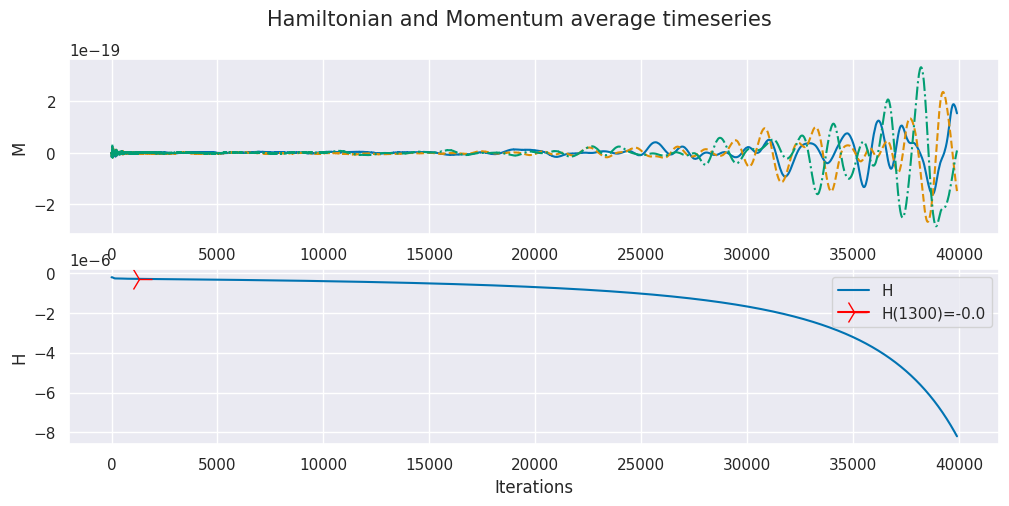

In [9]:
M1 = sim.timeseries.average['M1']
M2 = sim.timeseries.average['M2']
M3 = sim.timeseries.average['M3']
H  = sim.timeseries.average['H']

li=12
plt.figure(figsize=(12,5))
plt.suptitle("Hamiltonian and Momentum average timeseries", fontsize=15)
plt.subplot(2,1,1)
plt.plot(M1.y[:-li], label='M1')
plt.plot(M3.y[:-li], label='M2', linestyle='--')
plt.plot(M2.y[:-li], label='M3', linestyle='-.')
plt.ylabel('M')
#plt.legend()

n=1300
H_n = round(H.y[n],4)
plt.subplot(2,1,2)
plt.plot(H.y[:-li], label='H')
plt.plot(n, H.y[n], label=f'H({n})={H_n}', color="red", marker="4", markersize=18)
plt.xlabel('Iterations')
plt.ylabel('H')
plt.legend()

# Grid Functions

In [10]:
# Define grid functions

kxx, gxx = sim.gf.xyz['kxx'], sim.gf.xyz['gxx']               # sim.gf.dim['var'][iteration]
kxy, gxy = sim.gf.xyz['kxy'], sim.gf.xyz['gxy']
kxz, gxz = sim.gf.xyz['kxz'], sim.gf.xyz['gxz']
kyy, gyy = sim.gf.xyz['kyy'], sim.gf.xyz['gyy']
kyz, gyz = sim.gf.xyz['kyz'], sim.gf.xyz['gyz']
kzz, gzz = sim.gf.xyz['kzz'], sim.gf.xyz['gzz']

rho = sim.gf.xyz['rho']

## z-slices

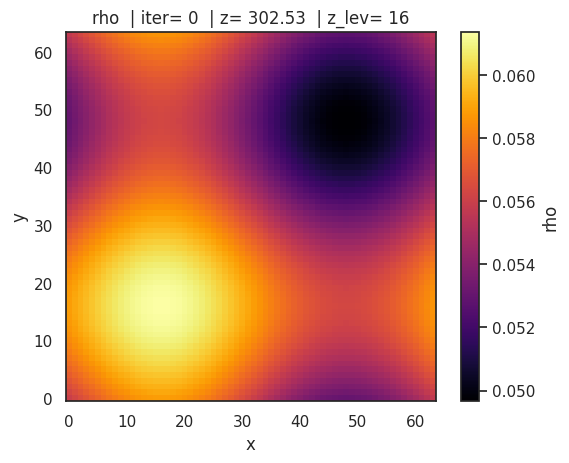

In [25]:
# z_slices

plot_z_slice(var=rho, i=0, z=16, var_name='rho')

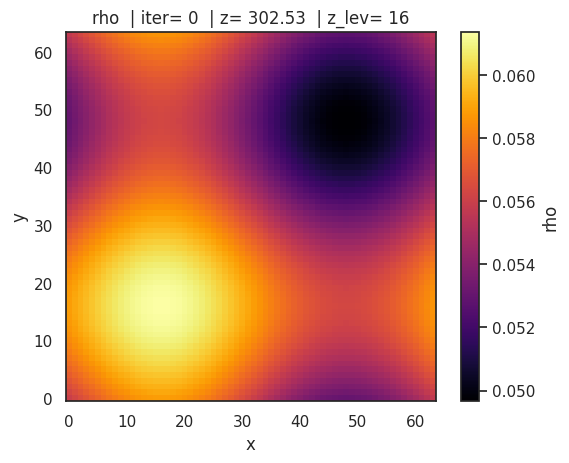

In [ ]:
plot_z_slice(var=rho, i=0, z=48, var_name='rho')

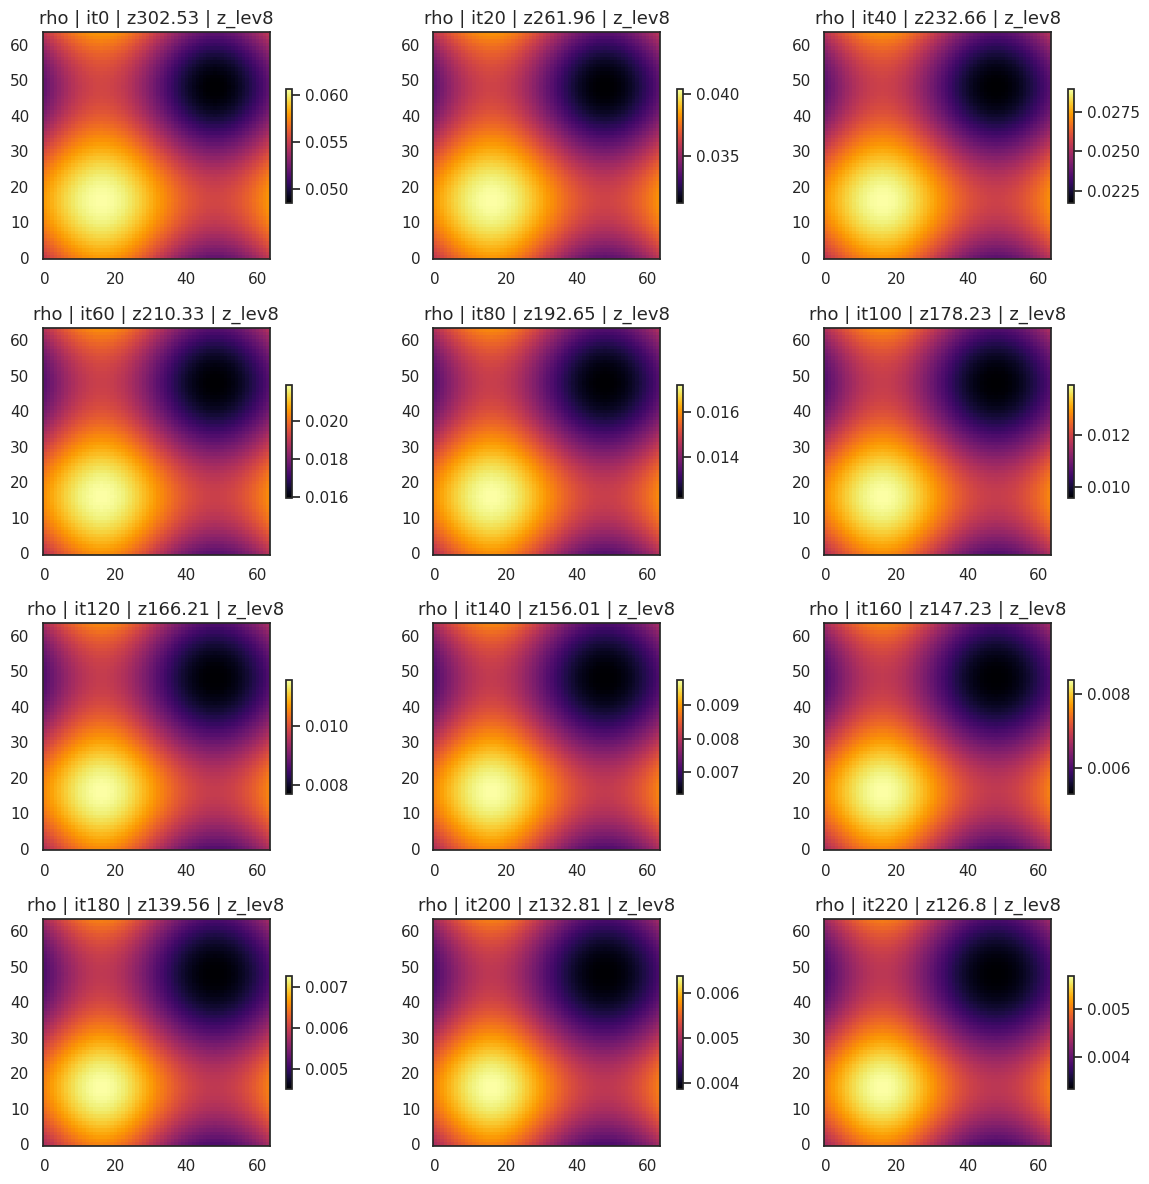

In [16]:
# Fix z_level, different iterations

plt.figure(figsize=(12,12))
sns.set_style("white") 
for j in range(12):
    plt.subplot(4,3,j+1)
    plot_z_slice_clean(var=rho, i=avail_iter[j], z=8, var_name='rho')

plt.tight_layout()    

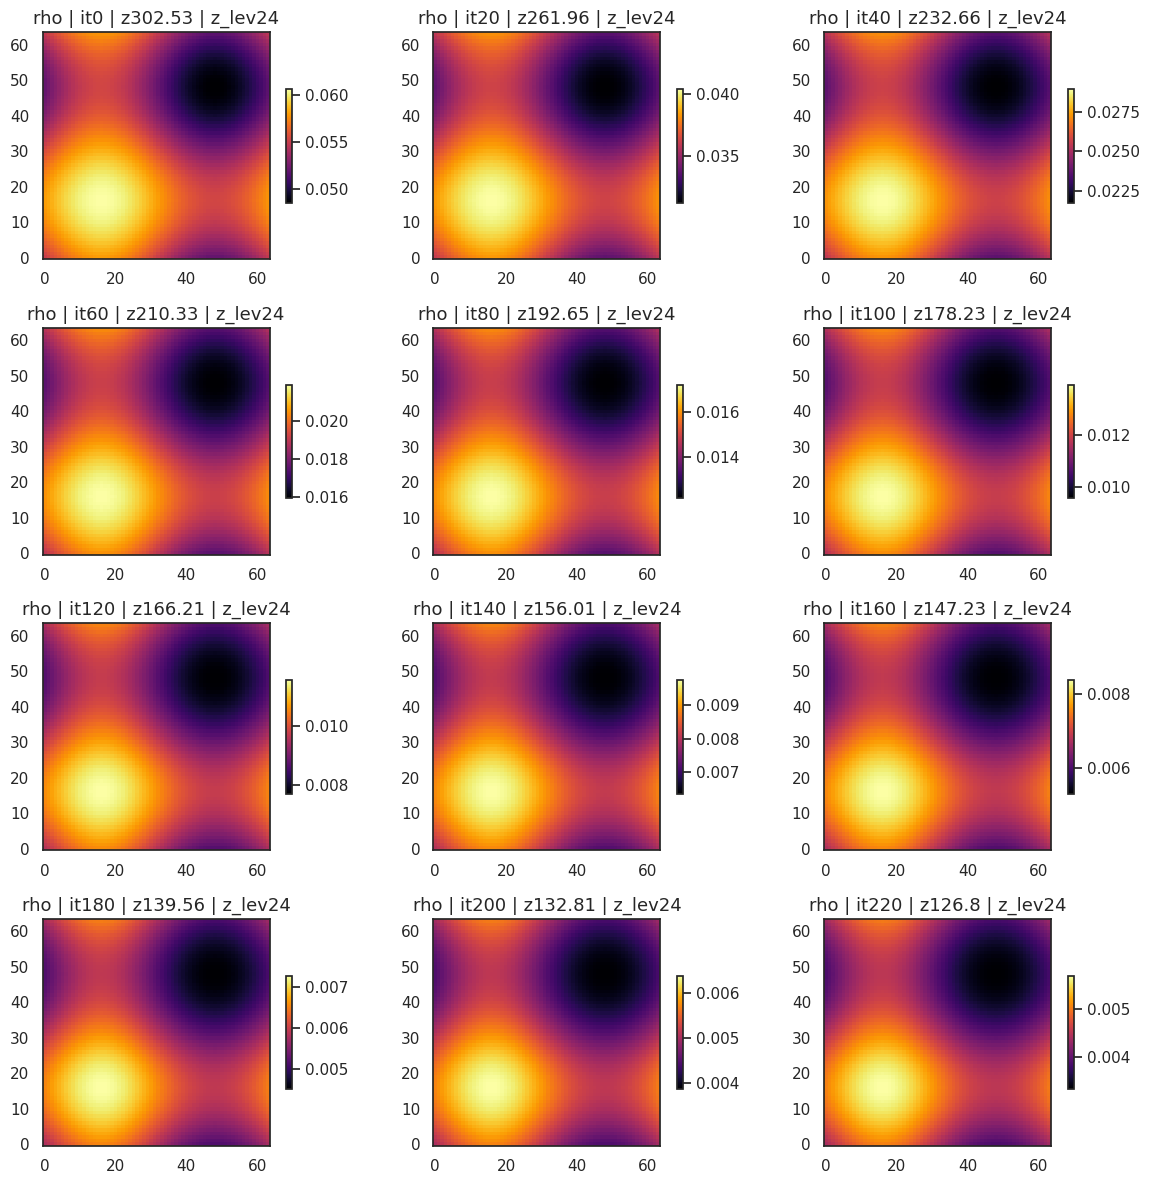

In [17]:
# # Fix z_level, different iterations

plt.figure(figsize=(12,12))
sns.set_style("white") 
for j in range(12):
    plt.subplot(4,3,j+1)
    plot_z_slice_clean(var=rho, i=avail_iter[j], z=32-8, var_name='rho')

plt.tight_layout()    

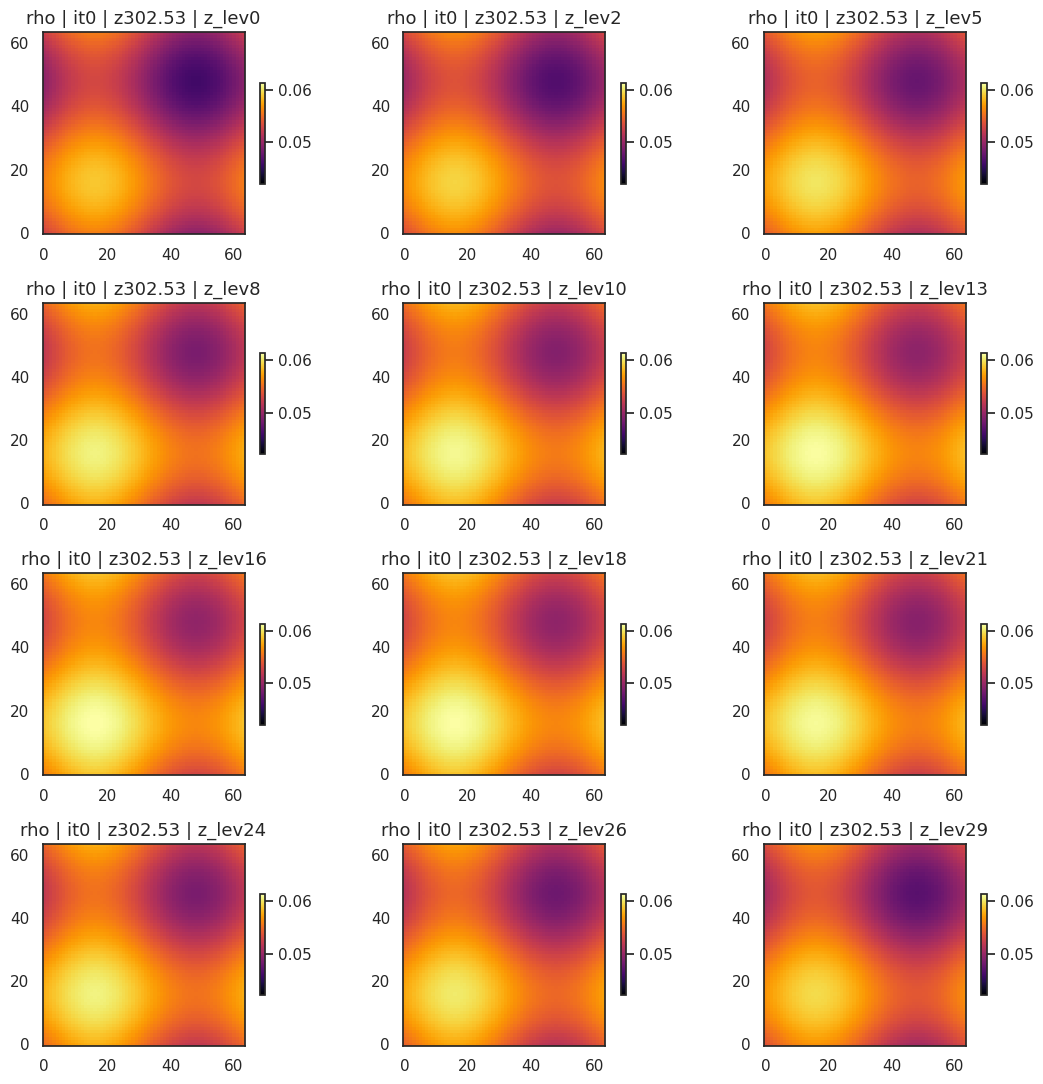

In [ ]:
# Fix iteration, different z-levels

iteration=0

plt.figure(figsize=(11,11))
sns.set_style("white") 
for j in range(12):
    plt.subplot(4,3,j+1)
    plot_z_slice_clean(var=rho, i=iteration, z=j*32//12, var_name='rho', norm=True)

plt.tight_layout()  

# Some nice feature would be adding a marker (and label) for the max and min value, this will give us an idea for the OD and UD location

**Note**: the normalization of the colorbar is gonna be useful only for visualizing the same iteration 

## Box-surfaces plots

<Figure size 700x700 with 0 Axes>

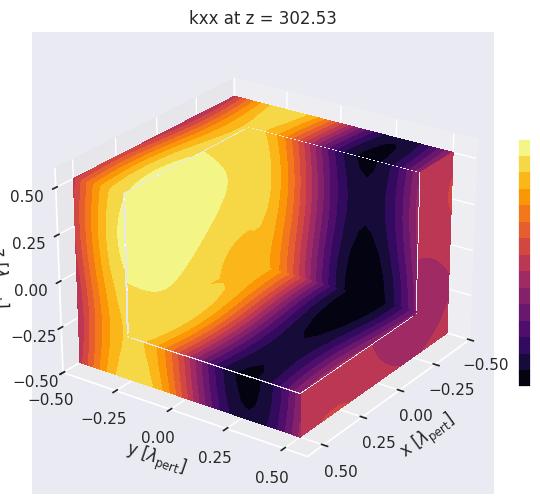

In [76]:
sns.set_theme(context='notebook', style='darkgrid', palette='colorblind')
plt.figure(figsize=(7,7))
plot_box_sufaces(box_size=32, var=kxx, iter=0, levels=16, title='kxx', figsize=(8, 6))

<Figure size 700x700 with 0 Axes>

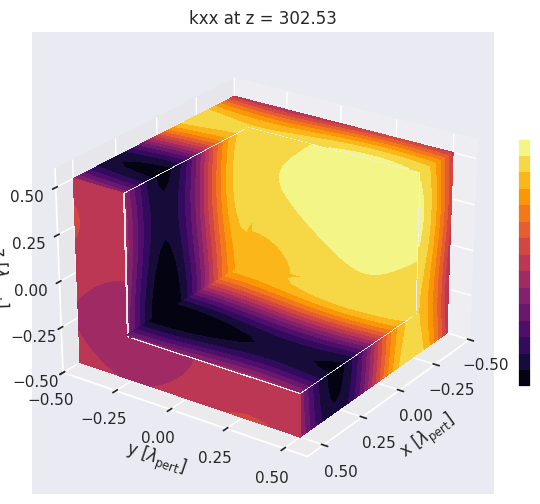

In [ ]:
sns.set_theme(context='notebook', style='darkgrid', palette='colorblind')
plt.figure(figsize=(7,7))
plot_box_sufaces(box_size=32, var=kyy, iter=0, levels=16, title='kyy', figsize=(8, 6))

ValueError: Contour levels must be increasing

<Figure size 700x700 with 0 Axes>

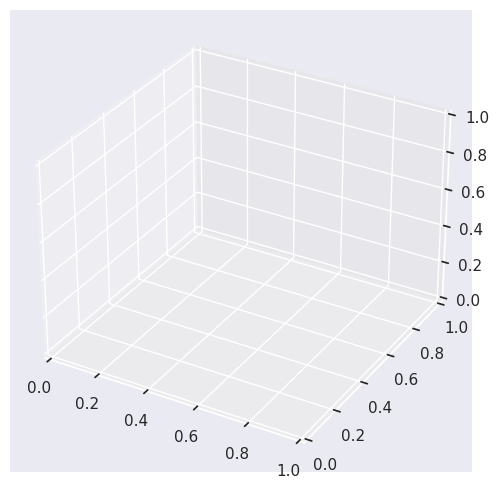

In [ ]:
#sns.set_theme(context='notebook', style='darkgrid', palette='colorblind')
#plt.figure(figsize=(7,7))
#plot_box_sufaces(box_size=32, var=kxy, iter=0, levels=16, title='kxy', figsize=(8, 6))

# Failed due to all zeros 
kxy[0][0][0][0].max()

<Figure size 700x700 with 0 Axes>

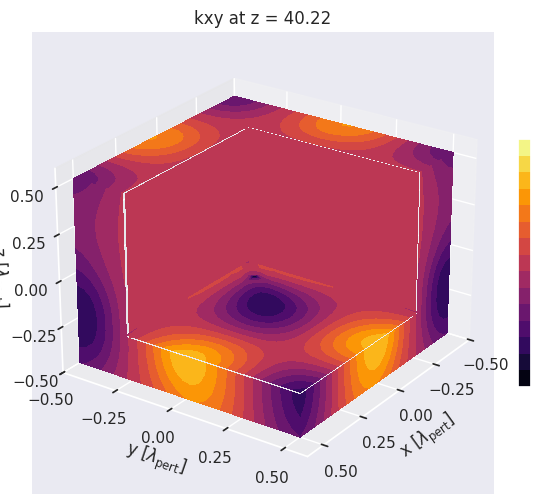

In [94]:
sns.set_theme(context='notebook', style='darkgrid', palette='colorblind')
plt.figure(figsize=(7,7))
plot_box_sufaces(box_size=32, var=kxy, iter=1400, levels=16, title='kxy', figsize=(8, 6), save=True, filename='k1400')

In [ ]:
# cctk time
t = np.array(M1.x)

# Constants
G=1.
Omega_matter0 = 0.3147              # from param.ccl "Matter Density Parameter Today"
Omega_lambda0 = 1. - Omega_matter0
ICPertFLRW_h = 0.6737                   #Dimenstionless hubble parameter
z_comoving_ref = 0.
a0 = 1. + z_comoving_ref            # "Comoving reference redshift: a_0 = 1 + z_comoving_ref"
H0 = ICPertFLRW_h * 1. / 2997.9         # Units are Mpc
t0_EdS= 2. / ( 3. * H0 )                # Used for both models

aa = a0 * (Omega_matter0 / Omega_lambda0 )**(1./3.) * (np.sinh( np.sqrt(Omega_lambda0) * t / t0_EdS ) ** (2./3.))                               #Follow ICCalc.F90 and param.ccl
Hprop = H0 * np.sqrt(Omega_matter0 * ( aa / a0 )**(-3.) + Omega_lambda0 )
Omega_matter = Omega_matter0 / ( Omega_matter0 + Omega_lambda0 * ( aa / a0 )**3.)
kappa = 8. * np.pi * G 
rhoflrw = 3. * Hprop**2. * Omega_matter / kappa

# Scalar, 1 for each cctk time
# Use s = aa/a0 to avoid some notation overload  

In [36]:
rhoflrw.shape

(3221,)

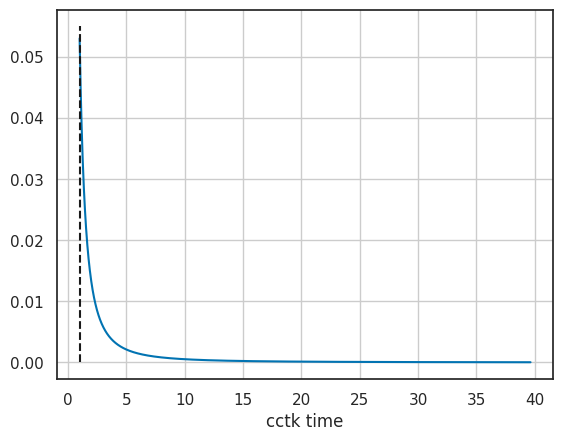

In [57]:
plt.plot(t, rhoflrw)               # matter density Lambda CDM background
plt.xlabel("cctk time")
plt.grid()
plt.vlines(1, ymin=0, ymax=0.055, linestyle="--", color='k')

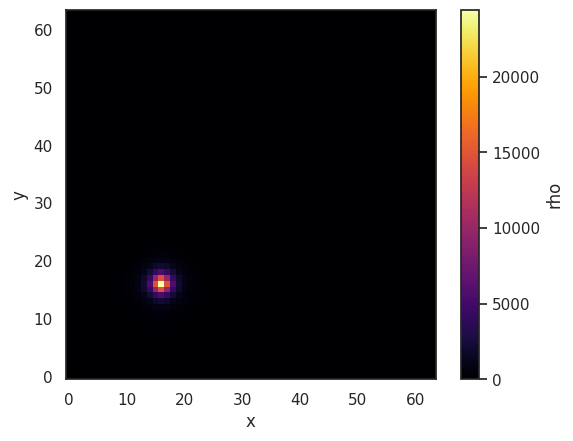

In [63]:
var = rho 
slice = var[3200][0][0][:, :, 17] / rhoflrw[3199] - 1
plt.imshow(slice, origin="lower", cmap="inferno")
plt.colorbar(label="rho")
plt.xlabel('x') 
plt.ylabel('y')

redshift = round(z_i(sim, i),2)
#plt.title(f'{"rho"}  | iter= {i}  | z= {redshift}  | z_lev= {z}')

In [37]:
rho[0][0][0][0]/rhoflrw[0] -1

array([[-0.00447759,  0.00141534,  0.00723635, ..., -0.02204693,
        -0.01626342, -0.01038868],
       [ 0.00141534,  0.00725099,  0.01301564, ..., -0.01598156,
        -0.0102551 , -0.00443801],
       [ 0.00723635,  0.01301564,  0.01872486, ..., -0.009991  ,
        -0.00432063,  0.00143977],
       ...,
       [-0.02204693, -0.01598156, -0.009991  , ..., -0.0401357 ,
        -0.03418025, -0.02813183],
       [-0.01626342, -0.0102551 , -0.00432063, ..., -0.03418025,
        -0.02828173, -0.0222908 ],
       [-0.01038868, -0.00443801,  0.00143977, ..., -0.02813183,
        -0.0222908 , -0.01635794]])

In [ ]:
plot_z_slice()

In [ ]:
# s=a/a0

# ADMAnalysis Ricci output test

In [2]:
sim = SimDir('/home/jorge/Downloads/output-0000/testPert32')

In [3]:
print(sim)

Indexed 28 files and 1 subdirectories
Folder /home/jorge/Downloads/output-0000/testPert32
/home/jorge/Downloads/output-0000/testPert32
Available scalar timeseries:
[]

Available minimum timeseries:
[]

Available maximum timeseries:
[]

Available norm1 timeseries:
[]

Available norm2 timeseries:
[]

Available average timeseries:
['kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'alp', 'H', 'rho', 'betax', 'betay', 'betaz', 'M1', 'M2', 'M3']
Variables available: dict_keys([])

Available grid data of dimension 1D (x): 
[]


Available grid data of dimension 1D (y): 
[]


Available grid data of dimension 1D (z): 
[]


Available grid data of dimension 2D (xy): 
[]


Available grid data of dimension 2D (xz): 
[]


Available grid data of dimension 2D (yz): 
[]


Available grid data of dimension 3D (xyz): 
['kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'Ricci11', 'Ricci12', 'Ricci13', 'Ricci22', 'Ricci23', 'Ricci33', 'Ricci', 'NaNmask', 'rho', 'gxx', 'gxy', 'gxz',

In [4]:
# Available iterations

avail_iter = sim.gf.xyz['kxx'].available_iterations 
print(f'{sim.gf.xyz['kxx'].available_iterations[:3]} ... {sim.gf.xyz['kxx'].available_iterations[-3:]}')

[0, 20, 40] ... [1360, 1380, 1400]


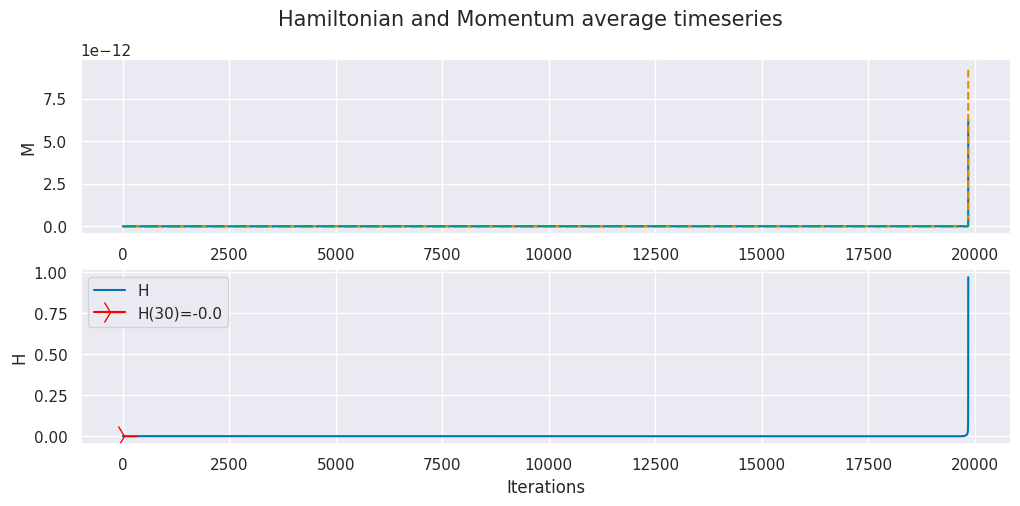

In [14]:
M1 = sim.timeseries.average['M1']
M2 = sim.timeseries.average['M2']
M3 = sim.timeseries.average['M3']
H  = sim.timeseries.average['H']


li=3
plt.figure(figsize=(12,5))
plt.suptitle("Hamiltonian and Momentum average timeseries", fontsize=15)
plt.subplot(2,1,1)
plt.plot(M1.y[:-li], label='M1')
plt.plot(M3.y[:-li], label='M2', linestyle='--')
plt.plot(M2.y[:-li], label='M3', linestyle='-.')
plt.ylabel('M')
#plt.legend()

n=30
H_n = round(H.y[n],4)
plt.subplot(2,1,2)
plt.plot(H.y[:-li], label='H')
plt.plot(n, H.y[n], label=f'H({n})={H_n}', color="red", marker="4", markersize=18)
plt.xlabel('Iterations')
plt.ylabel('H')
plt.legend()

# hold on, I think this is not plotting the iteartion in the x axis

In [15]:
# cctk time
t = np.array(M1.x)

# Constants
G=1.
Omega_matter0 = 0.3147              # from param.ccl "Matter Density Parameter Today"
Omega_lambda0 = 1. - Omega_matter0
ICPertFLRW_h = 0.6737                   #Dimenstionless hubble parameter
z_comoving_ref = 0.
a0 = 1. + z_comoving_ref            # "Comoving reference redshift: a_0 = 1 + z_comoving_ref"
H0 = ICPertFLRW_h * 1. / 2997.9         # Units are Mpc
t0_EdS= 2. / ( 3. * H0 )                # Used for both models

aa = a0 * (Omega_matter0 / Omega_lambda0 )**(1./3.) * (np.sinh( np.sqrt(Omega_lambda0) * t / t0_EdS ) ** (2./3.))                               #Follow ICCalc.F90 and param.ccl
Hprop = H0 * np.sqrt(Omega_matter0 * ( aa / a0 )**(-3.) + Omega_lambda0 )         # H
Omega_matter = Omega_matter0 / ( Omega_matter0 + Omega_lambda0 * ( aa / a0 )**3.)
kappa = 8. * np.pi * G 
rhoflrw = 3. * Hprop**2. * Omega_matter / kappa

In [ ]:
aa[:39921:80].shape         # To match the spacing of the grid functions

(500,)

In [24]:
# Define grid functions

kxx, gxx = sim.gf.xyz['kxx'], sim.gf.xyz['gxx']               # sim.gf.dim['var'][iteration]
kxy, gxy = sim.gf.xyz['kxy'], sim.gf.xyz['gxy']
kxz, gxz = sim.gf.xyz['kxz'], sim.gf.xyz['gxz']
kyy, gyy = sim.gf.xyz['kyy'], sim.gf.xyz['gyy']
kyz, gyz = sim.gf.xyz['kyz'], sim.gf.xyz['gyz']
kzz, gzz = sim.gf.xyz['kzz'], sim.gf.xyz['gzz']

Rxx, Ryy, Rzz = sim.gf.xyz['Ricci11'], sim.gf.xyz['Ricci22'], sim.gf.xyz['Ricci33']
Rxy, Rxz = sim.gf.xyz['Ricci12'], sim.gf.xyz['Ricci13']
Ryz = sim.gf.xyz['Ricci23']
R = sim.gf.xyz['Ricci']
rho = sim.gf.xyz['rho']

In [13]:
# Check OD and UD values

max(R[0][0][0][:,:,:].flatten()), min(R[0][0][0][:,:,:].flatten())

(0.1083716117954072, -0.1041288039047589)

In [14]:
# Position of the OD and UD for this 32box

R[0][0][0][8, 8, 8], R[0][0][0][-8, -8, -8]

(0.1083716117954072, -0.1041288039047589)

In [21]:
R[20][0][0][8, 8, 8]

1.0281406560839184

In [22]:
R_OD_list = [R[i][0][0][8, 8,  8] for i in range(0,1401,20)]
R_UD_list = [R[i][0][0][-8,-8,-8] for i in range(0,1401,20)]


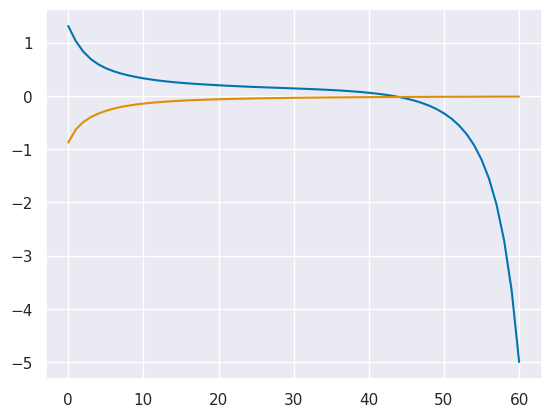

In [29]:
short = 10

plt.plot(R_OD_list[:-short], label='R_OD')
plt.plot(R_UD_list[:-short], label='R_UD')

Text(0.5, 0, 'a/a0')

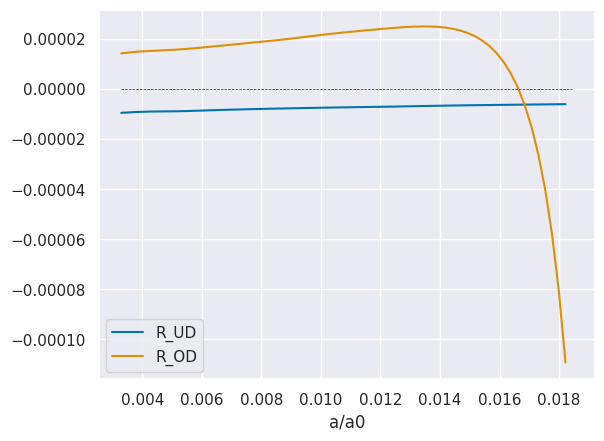

In [40]:
# Now w.r.t. the scale factor and also multiply by a^2

short = 20

plt.plot(aa[:-short]/a0,(aa**2 *R_UD_list)[:-short], label='R_UD')
plt.plot(aa[:-short]/a0,(aa**2 *R_OD_list)[:-short], label='R_OD')
plt.hlines(y=0, xmin=aa[0], xmax=aa[-short], linestyle='--', linewidth=.5, color='k')
plt.legend()
plt.xlabel('a/a0')

- Well, this simulation clearly crashed pretty soon
- Cut iterations based on the violations to the Hamiltonian constraint (H plot above)
- We still need to plot this in terms of $\lambda_{pert}^{-2}$

Text(0.5, 0, 'a/a0')

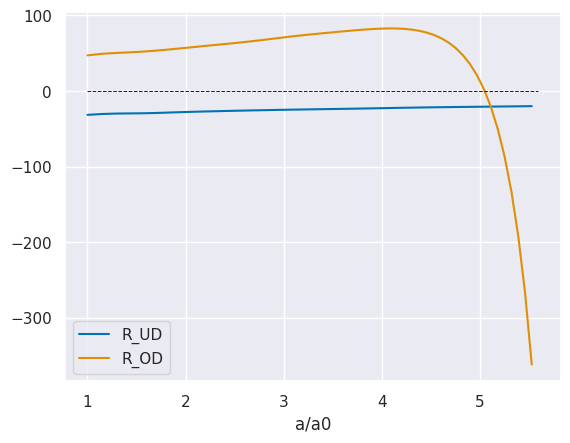

In [ ]:
# Now w.r.t. the scale factor and also multiply by a^2

short = 20
l_pert = 1821     # lambda_pert  [Mpc] 

plt.plot(aa[:-short]/aa[0],l_pert**2*(aa**2 *R_UD_list)[:-short], label='R_UD')
plt.plot(aa[:-short]/aa[0],l_pert**2*(aa**2 *R_OD_list)[:-short], label='R_OD')
plt.hlines(y=0, xmin=1, xmax=aa[-short]/aa[0], linestyle='--', linewidth=.7, color='k')
plt.legend()
plt.xlabel('a/a0')

Well well, this looks a lot more like the plot from the paper

Assignment: make functions for all different plots taken as input only the simulation directory and some parameters 

# Try and plot the ricci with the $\gamma^{1/3}$

First, we try and correctly calculate the determinant of the spatial metric and plot $\delta\gamma$

In [ ]:
# metric diagonal components at the OD and UD 

gxx_od_list = np.array([gxx[i][0][0][8, 8,  8] for i in range(0,1401,20)])
gxx_ud_list = np.array([gxx[i][0][0][-8,-8,-8] for i in range(0,1401,20)])
gyy_od_list = np.array([gyy[i][0][0][8, 8,  8] for i in range(0,1401,20)])
gyy_ud_list = np.array([gyy[i][0][0][-8,-8,-8] for i in range(0,1401,20)])
gzz_od_list = np.array([gzz[i][0][0][8, 8,  8] for i in range(0,1401,20)])
gzz_ud_list = np.array([gzz[i][0][0][-8,-8,-8] for i in range(0,1401,20)])

# off diagonal components

gxy_od = pass

gamma_od = gxx_od * pass

# Not good enough

In [22]:
def gamma_3x3_det(iter, x, y, z):
    '''takes iteration number and position and returns the determinant of the metric'''

    # all iterations, all positions
    g = np.array([[gxx, gxy, gxz],
                  [gxy, gyy, gyz],
                  [gxz, gyz, gzz]])
    
    # evaluate at iteration and position
    for i in itertools.product(range(3), repeat=2):
        g[i] = g[i][iter][0][0][x,y,z]

    g2 = g.astype(np.float64)       # to avoid mixing objects 

    return np.linalg.det(g2)    

In [25]:
gamma_od = [gamma_3x3_det(i, 8, 8, 8) for i in avail_iter]
gamma_ud = [gamma_3x3_det(i,-8,-8,-8) for i in avail_iter]
gamma_ct = [gamma_3x3_det(i,16,16,16) for i in avail_iter]

In [26]:
aa_coarse = aa[:avail_iter_max+1:diter]

In [27]:
delta_gamma_od = np.array(gamma_od)/aa_coarse**6 -1
delta_gamma_ud = np.array(gamma_ud)/aa_coarse**6 -1
delta_gamma_ct = np.array(gamma_ct)/aa_coarse**6 -1


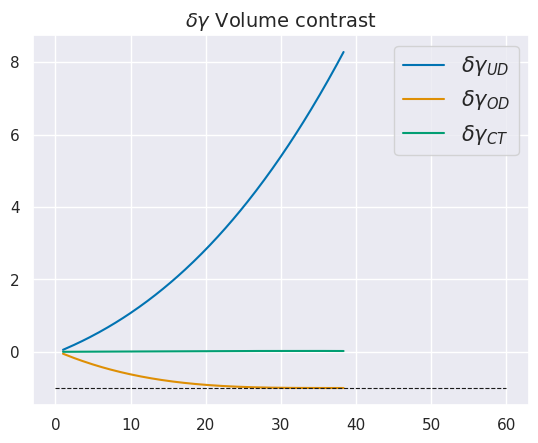

In [28]:
short = avail_iter_max//diter

plt.title(r'$\delta\gamma$ Volume contrast', fontsize=14)
plt.plot(aa_coarse[:short]/aa[0], delta_gamma_ud[:short], label=r'$\delta\gamma_{UD}$')
plt.plot(aa_coarse[:short]/aa[0], delta_gamma_od[:short], label=r'$\delta\gamma_{OD}$')
plt.plot(aa_coarse[:short]/aa[0], delta_gamma_ct[:short], label=r'$\delta\gamma_{CT}$')
plt.legend(fontsize=15)

plt.hlines(y=-1, xmin=0, xmax=60, linestyle='--', colors='k', lw=.8)


- We're still a bit short, maybe we need to crank up the initial perturbation amplitude
- But, the determinant calculation appears to be correct!
- Now, compare this for other simulations and also with the `detofg` variable from ADMAnalysis
    - It works the same for both!
- Look for change of sign at around $a/a_{IN}\sim 3$

# Simulation G: Ricci, detofg and trace of K

In [5]:
sim = SimDir('/home/jorge/Downloads/output-0000/testPert32_G')

In [6]:
avail_iter = sim.gf.xyz['kxx'].available_iterations 
print(f'{sim.gf.xyz['kxx'].available_iterations[:3]} ... {sim.gf.xyz['kxx'].available_iterations[-3:]}')
avail_iter_max = avail_iter[-1]
diter = avail_iter[1]-avail_iter[0]

[0, 120, 240] ... [19560, 19680, 19800]


In [5]:
print(sim)

Indexed 34 files and 1 subdirectories
Folder /home/jorge/Downloads/output-0000/testPert32_G
/home/jorge/Downloads/output-0000/testPert32_G
Available scalar timeseries:
[]

Available minimum timeseries:
[]

Available maximum timeseries:
[]

Available norm1 timeseries:
[]

Available norm2 timeseries:
[]

Available average timeseries:
['kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'alp', 'H', 'rho', 'betax', 'betay', 'betaz', 'M1', 'M2', 'M3']
Variables available: dict_keys([])

Available grid data of dimension 1D (x): 
[]


Available grid data of dimension 1D (y): 
[]


Available grid data of dimension 1D (z): 
[]


Available grid data of dimension 2D (xy): 
[]


Available grid data of dimension 2D (xz): 
[]


Available grid data of dimension 2D (yz): 
[]


Available grid data of dimension 3D (xyz): 
['kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'Ricci11', 'Ricci12', 'Ricci13', 'Ricci22', 'Ricci23', 'Ricci33', 'Ricci', 'trK', 'detg', 'NaNmask', 'rho', '

In [ ]:
trk = sim.gf.xyz['trK']

In [11]:
trk_od_list = np.array([trk[i][0][0][ 8, 8, 8] for i in avail_iter])
trk_ud_list = np.array([trk[i][0][0][-8,-8,-8] for i in avail_iter])
trk_ct_list = np.array([trk[i][0][0][16,16,16] for i in avail_iter])

In [ ]:
H_coarse = Hprop[:avail_iter_max+1:diter]
aa_coarse= aa[:avail_iter_max+1:diter]

In [29]:
delta_k_od = trk_od_list/(-3.0*H_coarse) - 1.0
delta_k_ud = trk_ud_list/(-3.0*H_coarse) - 1.0
delta_k_ct = trk_ct_list/(-3.0*H_coarse) - 1.0

Text(0.5, 0, 'a/a_IN')

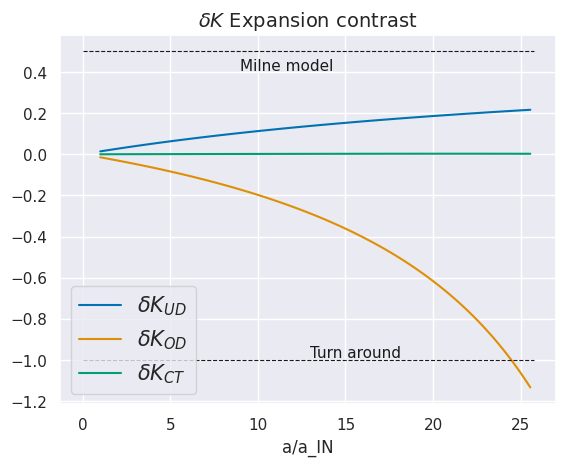

In [48]:
#short = avail_iter_max//diter
short = 90

plt.title(r'$\delta K$ Expansion contrast', fontsize=14)
plt.plot(aa_coarse[:short]/aa[0], delta_k_ud[:short], label=r'$\delta K_{UD}$')
plt.plot(aa_coarse[:short]/aa[0], delta_k_od[:short], label=r'$\delta K_{OD}$')
plt.plot(aa_coarse[:short]/aa[0], delta_k_ct[:short], label=r'$\delta K_{CT}$')
plt.hlines(y=-1, xmin=0, xmax=aa_coarse[short]/aa[0], linestyle='--', colors='k', lw=.8)
plt.text(13, -0.989, 'Turn around', fontsize=11, color='k')
plt.hlines(y=.5, xmin=0, xmax=aa_coarse[short]/aa[0], linestyle='--', colors='k', lw=.8)
plt.text(9, 0.41, 'Milne model', fontsize=11, color='k')
plt.legend(fontsize=15)
plt.xlabel('a/a_IN')



This suggest the perturbation is still too small, but it crashed too quick (I think)...

## Volume contrast using `detofg`

In [7]:
detg = sim.gf.xyz['detg']

In [9]:
detg[0][0][0][31, 23, 31]

1.3102078861577625e-15

In [32]:
# Try with detg (ADMAnalysis variable)

gamma_od = [detg[i][0][0][8, 8, 8] for i in avail_iter]
gamma_ud = [detg[i][0][0][-8,-8,-8] for i in avail_iter]
gamma_ct = [detg[i][0][0][16,16,16] for i in avail_iter]

In [33]:
aa_coarse = aa[:avail_iter_max+1:diter] 

In [34]:
delta_gamma_od = np.array(gamma_od)/aa_coarse**6 -1
delta_gamma_ud = np.array(gamma_ud)/aa_coarse**6 -1
delta_gamma_ct = np.array(gamma_ct)/aa_coarse**6 -1

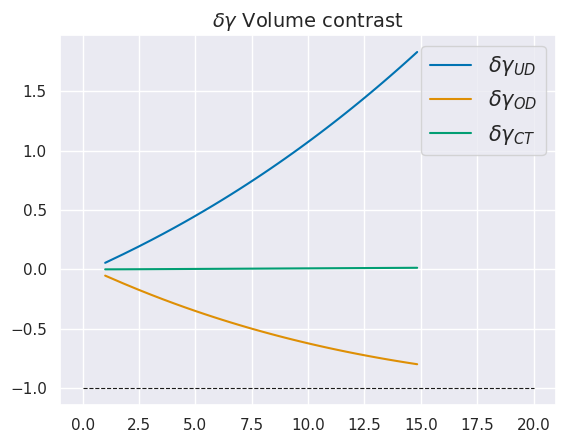

In [35]:
short = 40 #avail_iter_max//diter

plt.title(r'$\delta\gamma$ Volume contrast', fontsize=14)
plt.plot(aa_coarse[:short]/aa[0], delta_gamma_ud[:short], label=r'$\delta\gamma_{UD}$')
plt.plot(aa_coarse[:short]/aa[0], delta_gamma_od[:short], label=r'$\delta\gamma_{OD}$')
plt.plot(aa_coarse[:short]/aa[0], delta_gamma_ct[:short], label=r'$\delta\gamma_{CT}$')
plt.legend(fontsize=15)

plt.hlines(y=-1, xmin=0, xmax=20, linestyle='--', colors='k', lw=.8)


Damn it, no sign change!